# Image Classification: Pistachios

## MIDS W281: Computer Vision, Summer 2022

### Team members: Blake Bormes, Yu (Albert) Jiang, Deva Kulkarni

## Introduction

The focus of this project is to apply various computer vision techniques to classify images of pistachios. The dataset used in this project is made available on kaggle.com[1]. This dataset contains a total of 2148 images of two major types of pistachios grown in turkey, namely Kirmizi and Siirt. Since the prices, tastes, and nutritional values of these types differs, the type of pistachio becomes important when it comes to trade[2]. The dataset includes 1232 images of Kirmizi pistachios and 916 of Siirt Pistachios. 

The following report describes the Exploratory Data Analysis, Feature Extraction, Principal Component Analysis and Classification steps performed through the course of this project.



## Imports

In [1]:
#Importing libraries
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import seaborn as sns
from scipy.cluster.vq import vq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import spatial

## Load data

In [2]:
# csv file with pistachio names and labels
csv = pd.read_csv('pistachios_initial.csv', index_col = 0)

In [3]:
# pistachio_type 1 is Kirmizi, pistachio_type 0 is Siirt
csv.head()

,filename,filename_camelcase,pistachio_type
0,kirmizi (23).jpg,kirmizi_23.jpg,0
1,kirmizi 21.jpg,kirmizi_21.jpg,0
2,kirmizi 35.jpg,kirmizi_35.jpg,0
3,kirmizi 475.jpg,kirmizi_475.jpg,0
4,kirmizi 313.jpg,kirmizi_313.jpg,0


In [4]:
csv.pistachio_type.value_counts()

0    1232
1     916
Name: pistachio_type, dtype: int64

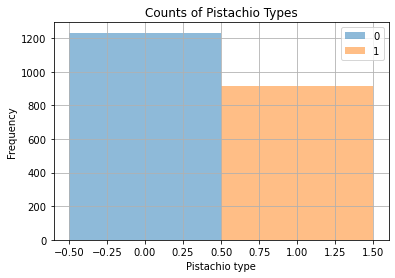

In [5]:
plt.hist(csv[csv.pistachio_type == 0].pistachio_type, bins = 1, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].pistachio_type, bins = 1, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Pistachio type')
plt.ylabel('Frequency')
plt.title('Counts of Pistachio Types')
plt.show()

In [6]:
images = [] #list of images

for fname in csv.filename.values:
    if "kirm" in fname:
        fname = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/{}".format(fname)
    else:
        fname = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/{}".format(fname)
    images.append(plt.imread(fname))

print('Total number of images: {}'.format(len(images)))
print('Shape of each image: {}'.format(images[0].shape))

Total number of images: 2148
Shape of each image: (600, 600, 3)


In [ ]:
#print list of rand ints to use for kirmizi image index
random.sample(range(0, 1232), 5)

In [ ]:
#print list of rand ints to use for siirt image index
random.sample(range(1232, 2148), 5)

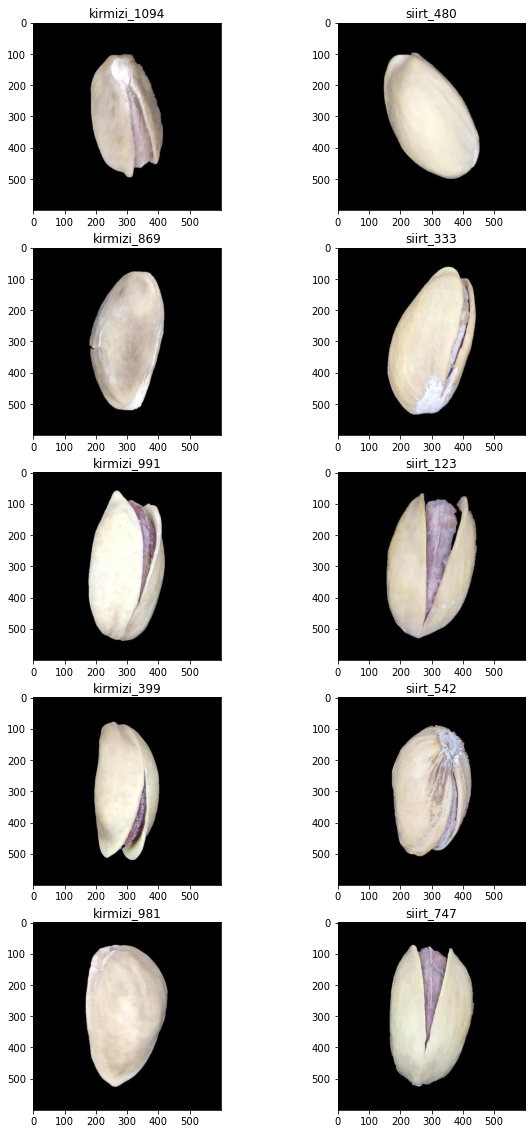

In [7]:
#Create list of random indexes to display random images
#Actually using random.randint gives differnet results for tsne later :/ )
random_image_index_kirmizi = [123, 234, 345, 456, 567]
random_image_index_siirt = [1234, 1345, 1456, 1567, 1678]


# Display examples images
fig, ax = plt.subplots(len(random_image_index_kirmizi),2, figsize = (10, 20))

for j, (index_0, index_1) in enumerate(zip(random_image_index_kirmizi, random_image_index_siirt)):
    
    ax[j, 0].imshow(images[index_0])
    ax[j, 0].set_title(csv.filename_camelcase[index_0][:-4])
    
    ax[j, 1].imshow(images[index_1])
    ax[j, 1].set_title(csv.filename_camelcase[index_1][:-4])      
        

Through simple visual inpsection, we see that Kirmizi pistachio (type 0) tend to be smaller than Siirt pistachios (type 1) on average. Kirmizi pistachios also tend to be longer and more slender than Siirt pistachios. There doesn't seem to be a clear difference in the shell or nut colors of the pistachios.

## EDA and Feature Extraction

- We look at the percentage of the image covered by the pistachio. We see that there is some separation between the two classes for this variable, with type 0 pistachios being slightly smaller than type 1 pistachios.

In [8]:
# Convert images to grayscale, and calculate the percentage area covered by the pistachio
grey_images = []
for img in images:
    grey_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

percent_area = []
for img in grey_images:
    percent_area.append(np.count_nonzero(img)/(img.shape[0]*img.shape[1]))

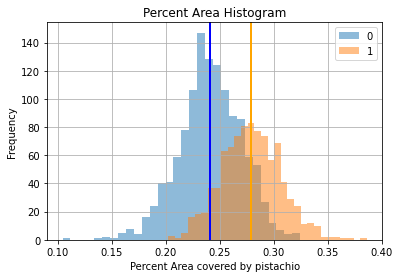

In [9]:
# Plot percent area for the two labels
csv['percent_area'] = percent_area

plt.hist(csv[csv.pistachio_type == 0].percent_area, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].percent_area, bins = 30, alpha = 0.5, label = 1)
plt.axvline(csv[csv.pistachio_type == 0].percent_area.mean(), color='blue', linewidth=2)
plt.axvline(csv[csv.pistachio_type == 1].percent_area.mean(), color='orange', linewidth=2)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Percent Area covered by pistachio')
plt.ylabel('Frequency')
plt.title('Percent Area Histogram')
plt.show()

- We fit an ellipse to the outer edges of the pistachio image. Using the fitted ellipse, we calculate the major axis, minor axis, area and perimeter. We further use these parameters to calculate eccentricity, equivalent diameter, extent, aspect ratio, compactness, roundness and four shape factors as defined below

***Add definitions of variables***

***Add code for fitting ellipse***

***Show sample images with pisatchio and fitted ellipse and major/minor axes***

***Maybe some plots showing distributions of some of the variables between the two classes?***

- To quantify the fit of the ellipse to the outer edges of the pisatchio, we calculate the distance of each point on the pistachio edge from the fitted ellipse. The final feature is the sum of all the distances for each pistachio scaled by the perimeter of the ellipse.

In [10]:
#Rescale and blur
rescaled_images = []
for img in grey_images:
    rescaled_images.append(cv2.GaussianBlur(cv2.resize(img, (200, 200)), (9, 9), 0))

def fit_ellipse(img):
    '''This function takes in an image of a pistachio and fits an ellipse to its outer edges.
    '''
    out_img = img.copy()            
    
    try:
        ret,thresh = cv2.threshold(out_img,5,255,0)
        contours,hierarchy = cv2.findContours(thresh, 1, 2) 
        cnt = contours[-1]
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt,True)
        ellipse = cv2.fitEllipse(cnt)
        return cv2.ellipse(out_img,ellipse,(255),2), cv2.ellipse(np.zeros_like(out_img),ellipse,(255),1), ellipse

    except cv2.error as e:
        pass

#Fit ellipse
ellipse_images = []
for img in rescaled_images:
    ellipse_images.append(fit_ellipse(img))
    
#Detect edges
def whiten_image(img):
    '''Take a rescaled and blurred image of pistachio, blow up pistachio to white,
    detect edges and return.
    '''    
    out_img = img.copy()
    out_img = np.where(out_img > 5, 255, 0).astype('uint8')
    return cv2.Canny(out_img, 100, 200)

white_patch_edge_detect = []
for img in rescaled_images:
    white_patch_edge_detect.append(whiten_image(img))


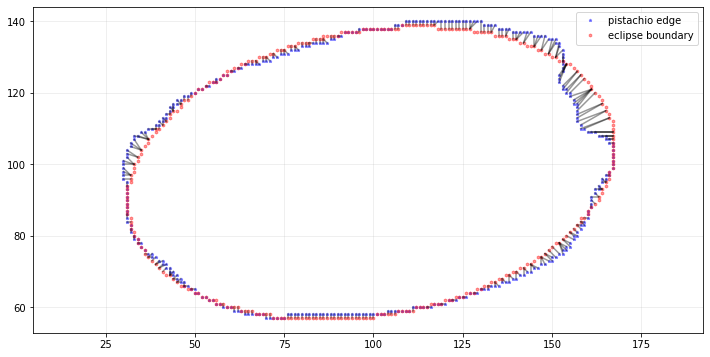

In [11]:
# Detect pistachio edge
pistachio_edge = np.argwhere(white_patch_edge_detect[random_image_index_kirmizi[0]] == 255)

# Detect ellipse 
ellipse_boundary = np.argwhere(ellipse_images[random_image_index_kirmizi[0]][1] == 255)

# For each point in pistachio_edge, find the closest point in ellipse_boundary:
code, dist = vq(pistachio_edge, ellipse_boundary)

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.plot(pistachio_edge[:,0], pistachio_edge[:,1], 'b*', markersize=3, alpha=0.4, label = 'pistachio edge')
plt.plot(ellipse_boundary[:,0], ellipse_boundary[:,1], 'rh', markersize=3, alpha=0.4, label = 'eclipse boundary')

for i, j in enumerate(code):
    plt.plot([pistachio_edge[i,0], ellipse_boundary[j,0]],
             [pistachio_edge[i,1], ellipse_boundary[j,1]], 'k', alpha=0.4)
plt.legend()
plt.grid(True, alpha=0.25)
plt.axis('equal')
plt.show()

In [12]:
def calculate_distance(ellipse_img, edge_img):
    '''This function calcualtes the minimum distance between points on 
    the edge image and points on the ellipse image. Returns total distance normalized by ellipse perimeter
    '''
    edge_points = np.argwhere(edge_img == 255)
    ellipse_points = np.argwhere(ellipse_img[1] == 255)
    code, dist = vq(edge_points, ellipse_points)
    return dist.sum()/calculate_perimeter(ellipse_img[2][1][0], ellipse_img[2][1][1])
    
def calculate_perimeter(a,b):
    perimeter = np.pi * ( 3*(a+b) - np.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

In [13]:
distance_from_ellipse = []
for i in range(len(images)):
    try:
        distance_from_ellipse.append(calculate_distance(ellipse_images[i], white_patch_edge_detect[i]))
    except:
        print(i)
        distance_from_ellipse.append(np.nan)

In [14]:
csv['distance_from_ellipse'] = distance_from_ellipse

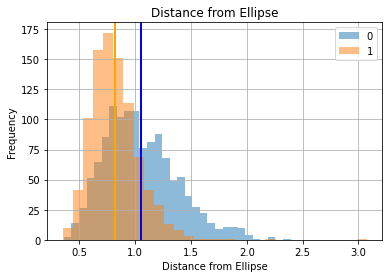

In [15]:
plt.hist(csv[csv.pistachio_type == 0].distance_from_ellipse, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].distance_from_ellipse, bins = 30, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.axvline(csv[csv.pistachio_type == 0].distance_from_ellipse.mean(), color='blue', linewidth=2)
plt.axvline(csv[csv.pistachio_type == 1].distance_from_ellipse.mean(), color='orange', linewidth=2)
plt.grid()
plt.xlabel('Distance from Ellipse')
plt.ylabel('Frequency')
plt.title('Distance from Ellipse')
plt.show()

We see that the distance of ellipse parameter does show some separation between the two classes. The ellipses tend to fit better for type 1 pistachios than type 2 pistachios on average.

We also look at the color data from each image. Specifically, we calculate the mean and median values for the pixels that depict the pistachio. We also calculate the mean and median value for each channel of the pistachio. In addition, we use k means clustering to separate the pixels into clusters that depict the pistachio shell and the pistachio nut and take the mean and median values for those

***Add code and plots showing color stuff**

*Add call out of notebooks where any features not yet included can be found (if needed)

### Learned features

### PCA analysis

In [51]:
#Importing hand coded and learned features from saved csv files.

# check if train, val, and test data already exist
if os.path.exists("pistachios_with_cnn_train.csv"):
    # if so, read them directly
    X_train = pd.read_csv("pistachios_with_cnn_train.csv", index_col=0)
    y_train = pd.read_csv("pistachios_with_cnn_train_labels.csv", index_col=0, squeeze=True)
    X_val = pd.read_csv("pistachios_with_cnn_val.csv", index_col=0)
    y_val = pd.read_csv("pistachios_with_cnn_val_labels.csv", index_col=0, squeeze=True)
    X_test = pd.read_csv("pistachios_with_cnn_test.csv", index_col=0)
    y_test = pd.read_csv("pistachios_with_cnn_test_labels.csv", index_col=0, squeeze=True)
else:
    # otherwise, read in the main data frame and split into train, val, and test
    df = pd.read_csv("pistachios_with_cnn.csv")
    X = df[df.columns[4:]]
    y = df["pistachio_type"]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

    # save train, val, and test for future use
    X_train.to_csv("pistachios_with_cnn_train.csv")
    y_train.to_csv("pistachios_with_cnn_train_labels.csv")
    X_val.to_csv("pistachios_with_cnn_val.csv")
    y_val.to_csv("pistachios_with_cnn_val_labels.csv")
    X_test.to_csv("pistachios_with_cnn_test.csv")
    y_test.to_csv("pistachios_with_cnn_test_labels.csv")

# separate hand coded features from the cnn features for train, val, and test
X_train_cnn = X_train[X_train.columns[-8:]].copy()
X_val_cnn = X_val[X_val.columns[-8:]].copy()
X_test_cnn = X_test[X_test.columns[-8:]].copy()
X_train.drop(X_train.columns[-8:], inplace=True, axis=1)
X_val.drop(X_val.columns[-8:], inplace=True, axis=1)
X_test.drop(X_test.columns[-8:], inplace=True, axis=1)

In [52]:
X_train_index = X_train.index
X_val_index = X_val.index
X_test_index = X_test.index

In [18]:
X_train_columns = X_train.columns
X_train_columns_cnn = X_train_cnn.columns

In [19]:
# use standard scaler to rescale by running fit and transform on hand coded train features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# apply the same transform to val and test
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

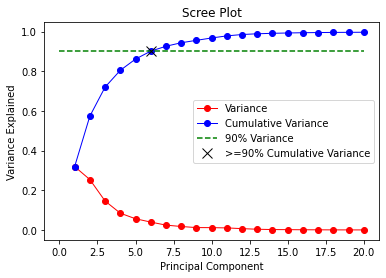

In [20]:
# define PCA model to use on hand coded features
n = 20
pca = PCA(n_components=n)

# fit PCA model
X_train = pca.fit_transform(X_train)
# get cumulative sum of variance and find the dimensions cutoff where we first reach >= 90% variance
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum >= 0.9)[0][0] + 1

# plot scree plot with variance, cumulative variance, and cutoff
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot([0, n], [0.9, 0.9], "g--", label="90% Variance")
plt.plot(cutoff, cum_sum[cutoff - 1], "kx", label=">=90% Cumulative Variance", markersize=10)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

# limit train, val, and test hand coded PCA features up to the first cutoff dimensions
X_train = X_train[:, :cutoff]
X_val = pca.transform(X_val)[:, :cutoff]
X_test = pca.transform(X_test)[:, :cutoff]

In [21]:
np.set_printoptions(linewidth=np.inf)
# Looking at which features contribute most to the first 5 PCA components
ind = np.flip((np.argsort(pca.components_[0:5,:])), axis = 1)

print('Features that contribute the most to 1st PCA component:')
print((X_train_columns[ind[0,:5]]).values)
print('')

print('Features that contribute the most to 2nd PCA component:')
print((X_train_columns[ind[1,:5]]).values)
print('')

print('Features that contribute the most to 3rd PCA component:')
print((X_train_columns[ind[2,:5]]).values)
print('')

print('Features that contribute the most to 4th PCA component:')
print((X_train_columns[ind[3,:5]]).values)
print('')

print('Features that contribute the most to 5th PCA component:')
print((X_train_columns[ind[4,:5]]).values)
print('')

Features that contribute the most to 1st PCA component:
['nut_b_means' 'n_nut_b_means' 'nut_v_means' 'nut_pixs_means' 'n_nut_v_means']

Features that contribute the most to 2nd PCA component:
['sf1' 'sf2' 'average_hue' 'n_shell_s_medians' 'shell_s_medians']

Features that contribute the most to 3rd PCA component:
['sf1' 'ec' 'k' 'shell_b_meds' 'n_shell_b_means']

Features that contribute the most to 4th PCA component:
['major_axis' 'major_axes' 'k' 'ec' 'ellipse_perimeters']

Features that contribute the most to 5th PCA component:
['shell_h_means' 'n_shell_h_means' 'shell_h_medians' 'n_shell_h_medians' 'average_hue']



- We only need 6 PCA features to explain 90% of variance
- The major contributors to the first PCA component are features related to means of the Blue color channel and the Value parameter in the HSV color scale for the pistachio nut.

- Subsequent PCA components contain features related to the shell colors the pistachio shape such as shape factors, eccentricity, aspect ratio and major and minor axis.

- This is expected because we see a large variance in the colors of the pistachio nuts, including some pistachios where the nut is not visible in the image. Some variance is seen in the shell colors, ranging from a bright white to a dull gray. The parameters of the fitted ellipse, in comparison, do not have as much variance across pistachios.

### TSNE analysis

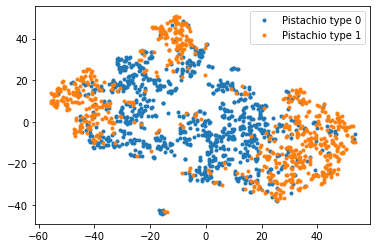

In [22]:
# use tSNE to plot hand coded train features after PCA dimensionality reduction in 2D
tsne = TSNE(n_components=2, random_state=0)
# rescale train PCA data so tSNE can treat dimensions with equal importance
tsne_X = tsne.fit_transform(scaler.fit_transform(X_train))
# plot tSNE of rescaled train PCA data
tsne_plot_x = tsne_X[:, 0]
tsne_plot_y = tsne_X[:, 1]
check_x_0 = tsne_plot_x[y_train == 0]
check_y_0 = tsne_plot_y[y_train == 0]
check_x_1 = tsne_plot_x[y_train == 1]
check_y_1 = tsne_plot_y[y_train == 1]
plt.plot(check_x_0, check_y_0, ".", label = 'Pistachio type 0')
plt.plot(check_x_1, check_y_1, ".", label = 'Pistachio type 1')
plt.legend()

- From the TSNE visualization of the first 6 PCA components, we see that there is some degree of separation between the two classes. Pistachio type 0 tends to be near the center of the plot while, pistachio type 1 tends to be at the either ends, though there is an appreciable overlap. There is also an interesting cluster of both classes at location ~(-17, -40) outside the general population.

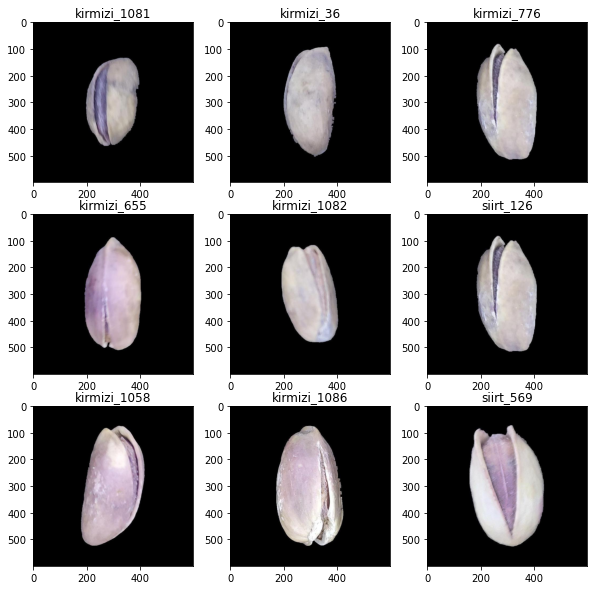

In [23]:
# Looking at 9 pistachios that end up closest to (-12, -40) in the tsne plot
tsne_coords = np.vstack([tsne_plot_x, tsne_plot_y])
pt = [-20, -40]
kdtree_ind = spatial.KDTree(tsne_coords.T).query(pt, k = 9)[1]

# Display examples images
fig, ax = plt.subplots(len(X_train_index[kdtree_ind])//3,3, figsize = (10, 10))

for j in range(0, 9, 3):
    ax[j//3, 0].imshow(images[X_train_index[kdtree_ind][j]])
    ax[j//3, 0].set_title(csv.filename_camelcase[kdtree_ind[j]][:-4])
    ax[j//3, 1].imshow(images[X_train_index[kdtree_ind][j+1]])
    ax[j//3, 1].set_title(csv.filename_camelcase[kdtree_ind[j+1]][:-4])
    ax[j//3, 2].imshow(images[X_train_index[kdtree_ind][j+2]])
    ax[j//3, 2].set_title(csv.filename_camelcase[kdtree_ind[j+2]][:-4])   
 

- The ouliers are pistachios with a purple-ish hue in the shell color. As seen previously, the largest contributions to the PCA components were by the pixel values inteh blue channel of the images, hence, Pistachio with peculiar colors get separated from the main population. These may need to be treated separately based on further investigation

### Logistic Regression of Features

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [43]:
# Use ‘sag’ and ‘saga’ solvers which are faster for large datasets
# ‘sag’ is supported by the following penalties [‘l2’, ‘none’]
# ‘saga’ is supported by the following penalties [‘l1’, ‘l2’, ‘none’]
solvers = ['sag','saga']

for i in solvers:
    if i == 'sag':
        logreg_sag_l2 = LogisticRegression(penalty = 'l2', solver = i)
        logreg_sag_l2.fit(X_train, y_train)
        validation_score_sag_l2 = logreg_sag_l2.score(X_val, y_val)
        logreg_sag_none = LogisticRegression(penalty = 'none', solver = i)
        logreg_sag_none.fit(X_train, y_train)
        validation_score_sag_none = logreg_sag_none.score(X_val, y_val)
    else:
        logreg_saga_l1 = LogisticRegression(penalty = 'l1', solver = i)
        logreg_saga_l1.fit(X_train, y_train)
        validation_score_saga_l1 = logreg_saga_l1.score(X_val, y_val)
        logreg_saga_l2 = LogisticRegression(penalty = 'l2', solver = i)
        logreg_saga_l2.fit(X_train, y_train)
        validation_score_saga_l2 = logreg_saga_l2.score(X_val, y_val)
        logreg_saga_none = LogisticRegression(penalty = 'none', solver = i)
        logreg_saga_none.fit(X_train, y_train)
        validation_score_saga_none = logreg_saga_none.score(X_val, y_val)
print(f"Validation set score for Sag solver and L2 penalty: {round(validation_score_sag_l2*100,2)}%. \n Validation set scor for Sag solver and none penalty: {round(validation_score_sag_none*100,2)}%. \n Validation set score for Saga solver and L2 penalty: {round(validation_score_saga_l1*100,2)}%. \nValidation set score for Saga solver and L2 penalty: {round(validation_score_saga_l2*100,2)}%. \n Validation set score for Saga solver and none penalty: {round(validation_score_saga_none*100,2)}%.")   

Validation set score for Sag solver and L2 penalty: 81.4%. 
 Validation set scor for Sag solver and none penalty: 81.4%. 
 Validation set score for Saga solver and L2 penalty: 81.65%. 
Validation set score for Saga solver and L2 penalty: 81.4%. 
 Validation set score for Saga solver and none penalty: 81.4%.


In [48]:
# Use Saga solver with L2 penalty on Test data
# init and fit logistic regression model to train PCA data
logreg = LogisticRegression(penalty = 'l2', solver = 'saga')
logreg.fit(X_train, y_train)

# print training and validation scores and classification metrics
training_score = logreg.score(X_train, y_train)
validation_score = logreg.score(X_val, y_val)
test_score = logreg.score(X_test, y_test)
print(f'Accuracy of logistic regression classifier on test set: {round(test_score*100,2)}% (validation {round(validation_score*100,2)}%) (training {round(training_score*100,2)}%)')
y_pred = logreg.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 87.44% (validation 81.4%) (training 83.89%)
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       122
           1       0.85      0.86      0.86        93

    accuracy                           0.87       215
   macro avg       0.87      0.87      0.87       215
weighted avg       0.87      0.87      0.87       215



Our Logistic regression model has an 87% accuracy on the test set after hyperparameter tuning.  The precision and recall scores are similar, with a higher precision and recall for type 0, meaning the nut of type 0 was more often identified as a nut of type 0 and of all nuts classified as type 0 89% of them were type 0. This makes sense because there were more type 0 nuts in the dataset.

In [69]:
logreg_df = pd.DataFrame(X_test_index, columns = ['Index'])
logreg_df['Actual_Class'] = y_test.to_numpy()
logreg_df['Predicted_Class'] = y_pred
logreg_df['Predicted_Prob'] = logreg.predict_proba(X_test.iloc[:, :6].values)[:,0]
logreg_df.head()

,Index,Actual_Class,Predicted_Class,Predicted_Prob
0,1859,1,1,1.0
1,1659,1,1,1.0
2,477,0,0,1.0
3,259,0,0,1.0
4,1708,1,1,1.0


In [70]:
# Class 0, Correctly Predicted
correct_0 = logreg_df.loc[(logreg_df.Actual_Class == 0) & (logreg_df.Predicted_Class == 0)]
correct_0_index = correct_0.sort_values(by = 'Predicted_Prob', ascending=False).Index[:4].to_numpy()

# Class 1, Correctly Predicted
correct_1 = logreg_df.loc[(logreg_df.Actual_Class == 1) & (logreg_df.Predicted_Class == 1)]
correct_1_index = correct_1.sort_values(by = 'Predicted_Prob', ascending=True).Index[:4].to_numpy()

# Class 0, Incorrectly Predicted
incorrect_0 = logreg_df.loc[(logreg_df.Actual_Class == 0) & (logreg_df.Predicted_Class == 1)]
incorrect_0_index = incorrect_0.sort_values(by = 'Predicted_Prob', ascending=True).Index[:4].to_numpy()

# Class 1, Incorrectly Predicted
incorrect_1 = logreg_df.loc[(logreg_df.Actual_Class == 1) & (logreg_df.Predicted_Class == 0)]
incorrect_1_index = incorrect_1.sort_values(by = 'Predicted_Prob', ascending=False).Index[:4].to_numpy()

Text(0.5, 0.98, 'Most confident Incorrect classifications')

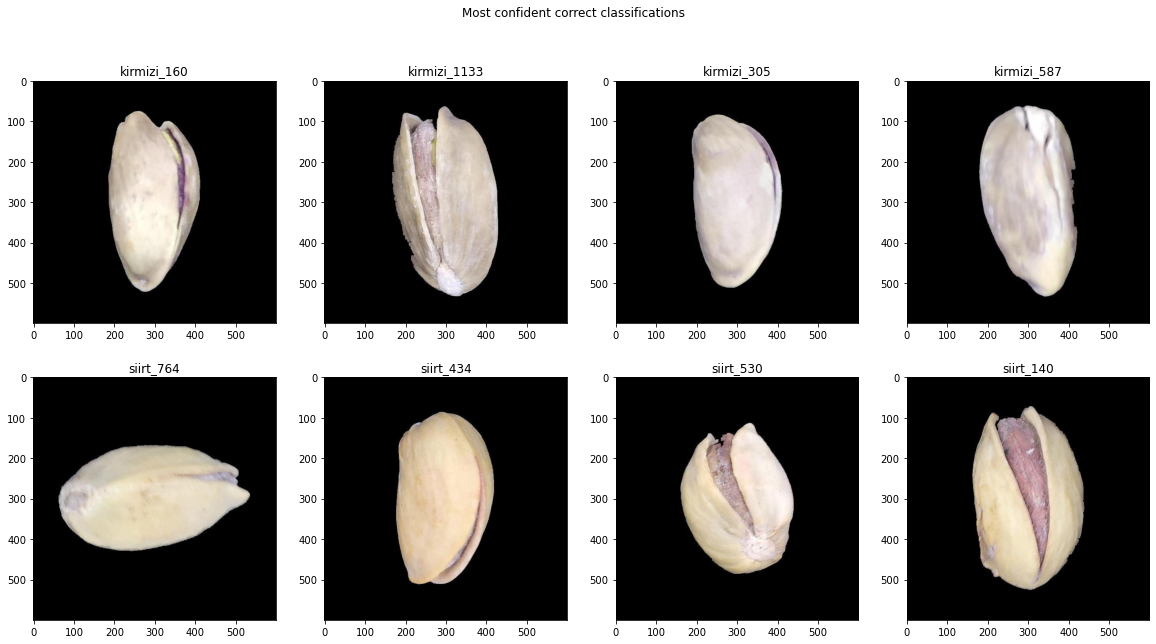

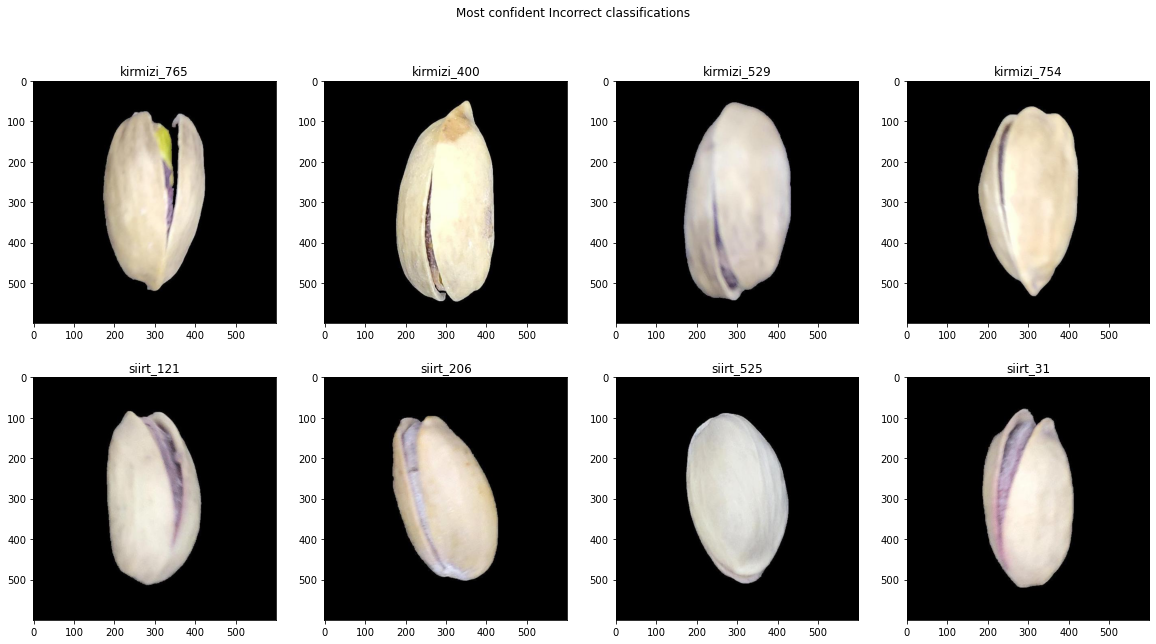

In [71]:
# Display examples images
fig, ax = plt.subplots(2,4, figsize = (20, 10))

for i in range(4):
    ax[0,i].imshow(images[correct_0_index[i]])
    ax[0,i].set_title(csv.filename_camelcase[correct_0_index[i]][:-4]) 
    
for i in range(4):
    ax[1,i].imshow(images[correct_1_index[i]])
    ax[1,i].set_title(csv.filename_camelcase[correct_1_index[i]][:-4]) 
    
plt.suptitle('Most confident correct classifications')
    
fig, ax = plt.subplots(2,4, figsize = (20, 10))
    
for i in range(4):
    ax[0,i].imshow(images[incorrect_0_index[i]])
    ax[0,i].set_title(csv.filename_camelcase[incorrect_0_index[i]][:-4]) 
    
for i in range(4):
    ax[1,i].imshow(images[incorrect_1_index[i]])
    ax[1,i].set_title(csv.filename_camelcase[incorrect_1_index[i]][:-4]) 
    
plt.suptitle('Most confident Incorrect classifications')


- It seems like the model is most confident in classifying type 0 (Kirmizi) pistachios that have a small size, and type 1 (Siirt) pistachios that have the largest size. Conversely, it incorrectly classifies large type 0 and small type 1 pistachios wrongly.

### SVM Model 

In [74]:
from sklearn import svm
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’} 
# init and fit rbf svc model to train PCA data
rbf_clf = svm.SVC(kernel='rbf')
rbf_clf.fit(X_train, y_train)
# print validation scores and classification metrics
rbf_validation_score = rbf_clf.score(X_val, y_val)
# continue for other kernels
lin_clf = svm.SVC(kernel='linear')
lin_clf.fit(X_train, y_train)
lin_validation_score = lin_clf.score(X_val, y_val)
poly_clf = svm.SVC(kernel='poly')
poly_clf.fit(X_train, y_train)
poly_validation_score = poly_clf.score(X_val, y_val)
sig_clf = svm.SVC(kernel='sigmoid')
sig_clf.fit(X_train, y_train)
sig_validation_score = sig_clf.score(X_val, y_val)
print(f'Accuracy of rbf svm classifier on validation set: {round(rbf_validation_score*100,2)}%. \n Accuracy of linear svm classifier on validation set: {round(lin_validation_score*100,2)}%. \n Accuracy of poly svm classifier on validation set: {round(poly_validation_score*100,2)}%. \n Accuracy of sigmoid svm classifier on validation set: {round(sig_validation_score*100,2)}%.')

Accuracy of rbf svm classifier on validation set: 74.68%. 
 Accuracy of linear svm classifier on validation set: 82.17%. 
 Accuracy of poly svm classifier on validation set: 74.16%. 
 Accuracy of sigmoid svm classifier on validation set: 28.94%.


In [76]:
# leverage our best model parameters (linear kernel) as the classifier
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
# print training and validation scores and classification metrics
training_score = clf.score(X_train, y_train)
validation_score = clf.score(X_val, y_val)
test_score = clf.score(X_test, y_test)
print('Accuracy of linear svm classifier on test set: {:.3f} (validation {:.3f}) (training {:.3f})'.format(test_score, validation_score, training_score))
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

Accuracy of linear svm classifier on test set: 0.902 (validation 0.822) (training 0.878)
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       122
           1       0.89      0.88      0.89        93

    accuracy                           0.90       215
   macro avg       0.90      0.90      0.90       215
weighted avg       0.90      0.90      0.90       215



- Our SVM model has a 90% accuracy on the test set after hyperparameter tuning. The precision and recall scores are similar, with a higher precision and recall for type 0, meaning the nut of type 0 was more often identified as a nut of type 0 and of all nuts classified as type 0 92% of them were type 0. This makes sense because there were more type 0 nuts in the dataset. 
- The SVM model performed with higher accuracy than the logistic regression model at an increase of ~3% accuracy.

### Models including CNN features

In [29]:
# combine hand coded PCA features with cnn PCA features after both had dimensions reduced
X_train_with_cnn = np.hstack([X_train, X_train_cnn])
X_val_with_cnn = np.hstack([X_val, X_val_cnn])
X_test_with_cnn = np.hstack([X_test, X_test_cnn])

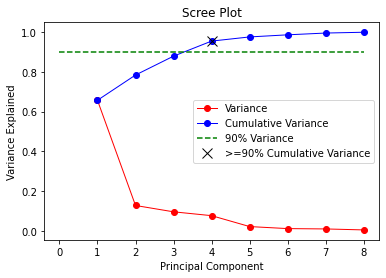

In [30]:
# use standard scaler to rescale by running fit and transform cnn train features
X_train_cnn = scaler.fit_transform(X_train_cnn)
# apply the same transform to val and test
X_val_cnn = scaler.transform(X_val_cnn)
X_test_cnn = scaler.transform(X_test_cnn)

# define PCA model to use on cnn features
n = 8
pca = PCA(n_components=n)

# fit PCA model
X_train_cnn = pca.fit_transform(X_train_cnn)
# get cumulative sum of variance and find the dimensions cutoff where we first reach >= 90% variance
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum >= 0.9)[0][0] + 1

# plot scree plot with variance, cumulative variance, and cutoff
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot([0, n], [0.9, 0.9], "g--", label="90% Variance")
plt.plot(cutoff, cum_sum[cutoff - 1], "kx", label=">=90% Cumulative Variance", markersize=10)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

# limit train, val, and test cnn PCA features up to the first cutoff dimensions
X_train_cnn = X_train_cnn[:, :cutoff]
X_val_cnn = pca.transform(X_val_cnn)[:, :cutoff]
X_test_cnn = pca.transform(X_test_cnn)[:, :cutoff]

It now takes us 4 PCA features to explain 90% of variance instead of 6. This is because we included our CNN features in our data.

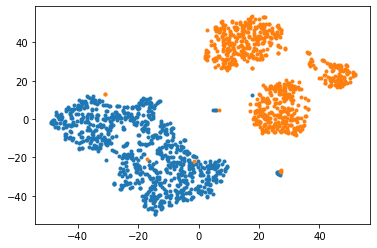

In [31]:
# use tSNE to plot combined features after PCA dimensionality reduction in 2D
tsne = TSNE(n_components=2, random_state=0)
# rescale combined train PCA data so tSNE can treat dimensions with equal importance
tsne_X_with_cnn = tsne.fit_transform(scaler.fit_transform(X_train_with_cnn))
# plot tSNE of rescaled combined train PCA data
tsne_plot_with_cnn_x = tsne_X_with_cnn[:, 0]
tsne_plot_with_cnn_y = tsne_X_with_cnn[:, 1]
check_x_with_cnn_0 = tsne_plot_with_cnn_x[y_train == 0]
check_y_with_cnn_0 = tsne_plot_with_cnn_y[y_train == 0]
check_x_with_cnn_1 = tsne_plot_with_cnn_x[y_train == 1]
check_y_with_cnn_1 = tsne_plot_with_cnn_y[y_train == 1]
plt.plot(check_x_with_cnn_0, check_y_with_cnn_0, ".")
plt.plot(check_x_with_cnn_1, check_y_with_cnn_1, ".")

- From the TSNE visualization of the first 4 PCA components, we see that there a clear separation between the two classes. Pistachio type 0 tends to be near the lower left corner of the plot while, pistachio type 1 tends to be at the upper right corner. There is minimal overlap along the center and few images that seem to be in the "wrong" cluster (i.e., orange in the blue section or blue in the orange section).

In [77]:
# init and fit logistic regression model to combined train PCA data
logreg = LogisticRegression(penalty = 'l2', solver = 'saga')
logreg.fit(X_train_with_cnn, y_train)

# print training and validation scores and classification metrics
training_score = logreg.score(X_train_with_cnn, y_train)
validation_score = logreg.score(X_val_with_cnn, y_val)
test_score = logreg.score(X_test_with_cnn, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f} (validation {:.3f}) (training {:.3f})'.format(test_score, validation_score, training_score))
y_pred = logreg.predict(X_test_with_cnn)
print(metrics.classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.958 (validation 0.961) (training 0.957)
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       122
           1       0.98      0.92      0.95        93

    accuracy                           0.96       215
   macro avg       0.96      0.95      0.96       215
weighted avg       0.96      0.96      0.96       215



/Users/blake/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


With the CNN features added to our dataset, the Logistic regression model has a test accuracy of 96%, a 9% increase from the logistic regression model that didn't use CNN features.

In [78]:
# init and fit rbf svc model to combined train PCA data
clf = svm.SVC(kernel='linear')
clf.fit(X_train_with_cnn, y_train)

# print training and validation scores and classification metrics
training_score = clf.score(X_train_with_cnn, y_train)
validation_score = clf.score(X_val_with_cnn, y_val)
test_score = clf.score(X_test_with_cnn, y_test)
print('Accuracy of linear svm classifier on test set: {:.3f} (validation {:.3f}) (training {:.3f})'.format(test_score, validation_score, training_score))
y_pred = clf.predict(X_test_with_cnn)
print(metrics.classification_report(y_test, y_pred))

Accuracy of linear svm classifier on test set: 1.000 (validation 0.997) (training 0.999)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00        93

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215



The SVM linear model accuracy increased by 10% when we included the CNN features. The model correctly classified 100% of test datapoints.

### Classification Discussion
- PCA was leveraged to compress our large amount of features, which reduced the dimensionality of the data. Additionally PCA helped denoise our data and simplified our features into either 4 or 6 main principle components. Drawbacks of leveraging PCA include low interpretability of principal components. When we discussed what features were included within certain principle components, occasionally shape & color data were leveraged for a single componenet, making the actual reasoning behind a single component less simple to understand. Additionally with dimensionality reduction, there's always a chance of information loss in our data. However, our model accuracy seemed to show that it was not that large of an issue. Lastly, PCA assumes correlation between features, which for some features, for example our shape-related features, there definitely was correlation. That being said for a shape feature and a color feature, we would assume less correlation. 
- TSNE worked very well with our data. It used a Gaussian kernel to define a soft border between data points. When modeling low dimensional coordinates, it weighted close and far datapoints at equal importances, which allowed us to represent our data in a properly weighted manner, finding key differences between features. Some drawbacks of using TSNE included less accuracy when analyzing 6 PCA features than just 4. When performing dimensionality reduction on larger numbers of dimensions, TSNE tends to perform worse. Additionally, if there were even more dimensions than 6, we could be sure that TSNE wouldn't do as good of a job to reduce the dimensionality of a high dimensional structure. 

### Generalizability Discussion
- We leveraged train data sets to train the initial model and validation data sets to perform hyperparameter tuning for both the Logistic Regression and SVM models. The test set was leveraged to determine final accuracy, while ensuring generalizability. In the future, our training process of the data could be improved by leveraging more data or an equal number of both types of nuts. This would allow the precision and recall of each nut type to be more similar. Overall, our model did a great job classifying the data and performed very well with the test data set, proving that our model's generalizability is strong.

### Conclusion
- In conclusion, we leveraged manual and CNN feature extraction of images to perform classification on two types of pistachios. We leveraged Logistic Regression and SVM models to classify the 2 types of nuts. The Linear kernel SVM model performed the best of all models, with a 90% accuracy on our features that didn't include CNN features, and 100% accuarcy on the features including manually extracted and CNN features. Through our TSNE analysis we saw that some training data had features that reflected the opposite class, but overall, there was a clear division between our data for each type of pistachio. In the future, we would continue to leverage PCA and TSNE to identify our best features and an SVM model to classify the data. However, we want to state that with PCA and TSNE, there is potential for data loss. Additionally, classification of Type 0 nuts had greater precision and recall than Type 1 nuts. In a future study, we would like to ensure the training set has equal representation of each type of nut and determine if that would improve our model's precision and recall scores. 

## References

[1] Pistachio Image Dataset https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset

[2] SINGH D, TASPINAR YS, KURSUN R, CINAR I, KOKLU M, OZKAN IA, LEE H-N., (2022). Classification and Analysis of Pistachio Species with Pre-Trained Deep Learning Models, Electronics, 11 (7), 981. https://doi.org/10.3390/electronics11070981. (Open Access)